In [2]:
import pandas as pd   
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

from numpy import mean

import warnings 
warnings.filterwarnings('ignore')

loading the Toyota Used Cars Sales data

In [3]:
df2 = pd.read_excel("DMforBA_DataSets\ToyotaCorolla.xls")
df2 = df2.loc[:, df2.columns != 'Id']
df = df2[['Price', 'Age_08_04', 'KM', 'Quarterly_Tax', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS','Airco', 'Metallic_Rim']]
X = df.loc[:, df.columns != 'Price']
y = df[['Price']]


comparing models using cross-validation

In [1]:
def fitting_models_CV():
    cv = RepeatedKFold(n_splits=10, n_repeats=1)#, random_state=1)
    
    lr=LinearRegression()
    ls = Lasso(alpha=10.5)
    rg = Ridge(alpha=1.5)
    dt = DecisionTreeRegressor(max_depth=5)
    rfr = RandomForestRegressor()
    gbr = GradientBoostingRegressor()
    knr = KNeighborsRegressor(n_neighbors=5)
    rgs = [('Linear Regression', lr),
        ('Lasso', ls),
        ('Ridge', rg),
        ('Decision Tree', dt),
        ('Gradient Boosting', gbr),
        ('Random Forest', rfr),        
        ('KNearest Neighbor',knr)       
    ]
    for name,rg in rgs:
        scores = cross_val_score(rg, X, y, cv=cv) 
        #rg.fit(X_train,y_train)
        #pred = rg.predict(X_test)
        score = format(mean(scores), '.4f')
        print("{} : {}".format(name,score))

In [4]:
fitting_models_CV()

Linear Regression : 0.8156
Lasso : 0.8133
Ridge : 0.8160
Decision Tree : 0.8688
Gradient Boosting : 0.8995
Random Forest : 0.8890
KNearest Neighbor : 0.3716


make a pipeline of knn

In [5]:
def fitting_models_CV2():
    cv = RepeatedKFold(n_splits=10, n_repeats=1)#, random_state=1)
    
    lr=LinearRegression()
    ls = Lasso(alpha=10.5)
    rg = Ridge(alpha=1.5)
    dt = DecisionTreeRegressor(max_depth=5)
    rfr = RandomForestRegressor()
    gbr = GradientBoostingRegressor()
    knr = KNeighborsRegressor(n_neighbors=5)
    pipe_knr = Pipeline([("scaler", MinMaxScaler()), 
                         ("knr", KNeighborsRegressor(n_neighbors=5))])
    rgs = [('Linear Regression', lr),
        ('Lasso Regression', ls),
        ('Ridge Regression', rg),
        ('Decision Tree', dt),
        ('Gradient Boosting', gbr),
        ('Random Forest', rfr),        
        ('KNearest Neighbor',knr),
        ('Scaled KNearest',pipe_knr)       
    ]
    for name,rg in rgs:
        start = time.perf_counter()
        scores = cross_val_score(rg, X, y, cv=cv) 
        end = time.perf_counter()
        #rg.fit(X_train,y_train)
        #pred = rg.predict(X_test)
        score = format(mean(scores), '.4f')
        duration = format((end-start),'.4f')
        print("{} : {} - {}".format(name,score,duration))

In [6]:
fitting_models_CV2()

Linear Regression : 0.8166 - 0.2020
Lasso Regression : 0.8187 - 0.1567
Ridge Regression : 0.8164 - 0.2002
Decision Tree : 0.8637 - 0.2654
Gradient Boosting : 0.8985 - 4.0359
Random Forest : 0.8908 - 11.1887
KNearest Neighbor : 0.3852 - 0.3404
Scaled KNearest : 0.8294 - 0.4917


hyperparameter optimization - gradient boosting regressor 

In [7]:
parameters = {'learning_rate': [0.05,0.1],#, 0.15],#,0.07,0.10],
                #'subsample'    : [0.9, 0.5, 0.2, 0.1],
                'n_estimators' : [100,200,300],#,400],
                'max_depth'    : [3,5,7]
                }
gbr = GradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=1)#, random_state=1)
grid_search = GridSearchCV(gbr, parameters, cv=cv, n_jobs=-1,verbose=3)#, refit=False)
grid_search.fit(X, y)
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
GradientBoostingRegressor()
0.8984643994505171
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


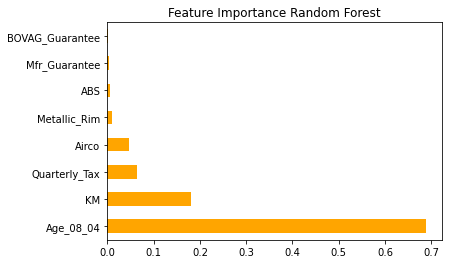

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
regRF = RandomForestRegressor(max_depth=6, max_features=4, min_samples_split=8,
                      n_estimators=300)#, random_state=0)
regRF.fit(X_train, y_train)
importance_rf = pd.Series(regRF.feature_importances_, index=X_train.columns)
importance_rf_sorted = importance_rf.sort_values()
importance_rf_sorted.nlargest(20).plot(kind='barh', color='orange')
plt.title("Feature Importance Random Forest")
plt.show()

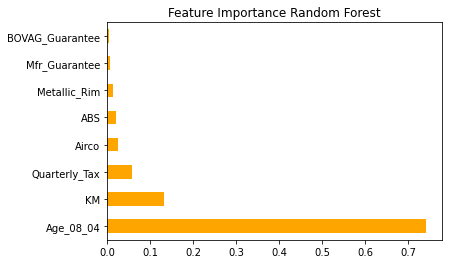

In [9]:
regGB = GradientBoostingRegressor(max_depth=10, max_features=4, min_samples_split=8,
                      n_estimators=300)#, random_state=0)
regGB.fit(X_train, y_train)
importance_rf = pd.Series(regGB.feature_importances_, index=X_train.columns)
importance_rf_sorted = importance_rf.sort_values()
importance_rf_sorted.nlargest(20).plot(kind='barh', color='orange')
plt.title("Feature Importance Random Forest")
plt.show()

In [10]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

In [11]:
cv = RepeatedKFold(n_splits=10, n_repeats=1)#, random_state=1)
reg_bg = BaggingRegressor(base_estimator=Ridge(1),
                        n_estimators=20, random_state=0)
scores = cross_val_score(reg_bg, X, y, cv=cv)
score = format(mean(scores), '.4f')
print(score)

0.8204


In [12]:
r1 = LinearRegression()
r2 = DecisionTreeRegressor(max_depth=5)
r3 = Pipeline([("scaler", MinMaxScaler()), 
                         ("knr", KNeighborsRegressor(n_neighbors=5))])

reg_vr = VotingRegressor([('lr', r1), ('dt', r2),('knn', r3)])
scores = cross_val_score(reg_vr, X, y, cv=cv)
score = format(mean(scores), '.4f')
print(score)

0.8776


In [14]:
estimators = [
('lr', LinearRegression()),
('dt', DecisionTreeRegressor(max_depth=5)),
('knn', Pipeline([("scaler", MinMaxScaler()), 
                         ("knr", KNeighborsRegressor(n_neighbors=5))]))
]

reg_sr = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=100,random_state=42))
scores = cross_val_score(reg_sr, X, y, cv=cv)
score = format(mean(scores), '.4f')
print(score)

0.0346


In [15]:
from sklearn.datasets import make_regression
import numpy as np

In [16]:
X, y = make_regression(n_samples=10000, n_features=2,
        n_informative=2, n_targets=1,
        random_state=0, shuffle=False)

In [17]:
x1 = np.random.normal(0, 3, 10000)
x2 = np.random.normal(4, 2, 10000)
y = (1+(x1+x2+1)**2)#*(19-14*x1+3*x1^2-14*x2+6*x1*x2+3*x2^2)

In [ ]:
# f(x, y) = [1 + (x + y + 1)2(19 - 14x + 3x2 - 14y + 6xy + 3y2)]×[30 + (2x - 3y)2(18 - 32x + 12x2 + 48y - 36xy + 27y2)] 

In [18]:
y = (((1 + (X[:,0] + X[:,1] + 1)**2)*(19 - 14*X[:,0] + 3*X[:,0]**2 - 14*X[:,1] + 6*X[:,0]*X[:,1] + 3*X[:,1]**2)) *
    (30 + (2*X[:,0] - 3*X[:,1])**2 * (18 - 32*X[:,0] + 12*X[:,0]**2 + 48*X[:,1] - 36*X[:,0]*X[:,1] + 27*X[:,1]**2))) 

In [19]:
fitting_models_CV2()

Linear Regression : 0.0357 - 0.1098
Lasso Regression : 0.0500 - 0.0756
Ridge Regression : 0.0097 - 0.0643
Decision Tree : 0.4690 - 0.3018
Gradient Boosting : 0.8758 - 21.0505
Random Forest : 0.8761 - 115.7888
KNearest Neighbor : 0.7779 - 0.1685
Scaled KNearest : 0.7984 - 0.2256
